# Reinforcement Learning - Develop a Stock Market Trading Agent

We will develop a trading bot using Deep Q Learning Network. The Bot will make the decision to buy, sell and hold

## Library Imports

In [1]:
import math
import random
import numpy as np
import pandas_datareader as data_reader
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import deque

import tensorflow as tf

## Building the AI Trader Network

In [2]:
# Deep Q Network Model for AITrader

class AI_Trader:
    def __init__(self, state_size, action_space=3, model_name='AITrader'): # We have default three actions - stay, buy and sell

        # define hyperparamters of the network - also the attribute of this class
        self.state_size = state_size
        self.action_space = action_space
        self.memory = deque(maxlen=2000) # Experience replay memory
        self.inventory = [] # This list will hold all bought stocks, since we cannot sell a stock which we have not bought before
        self.model_name = model_name
        # This is that constant in the bellman's equation which tells how closer are we to the objective. This helps us to maximise the current reward over a long term reward.
        # The value can be set between 0.1 to 0.9
        self.gamma = 0.95
        # Epsilon parameter helps us to understand whether we will choose a random action or use the model for the same
        self.epsilon = 1.0 # This begins at the very beginning of the training process when our network is not trained, all actions are performed randomly
        # Over a period of time, when our network is trained, we would want the model to take actions and not random.. However we would still need sometimes some random action to be taken
        # By the agent, for environment exploration
        self.epsilon_final = 0.01
        # argument to denote, how fast the epsilon will reduce
        self.epsilon_decay = 0.995

        self.model = self.model_builder() # initialize the model and store it in model attribute of AITrader Class

    # Build the neural network model
    def model_builder(self):

        model = tf.keras.models.Sequential()
        model.add(tf.keras.layers.Dense(units=32, activation=tf.keras.activations.relu, input_dim=self.state_size))
        model.add(tf.keras.layers.Dense(units=64, activation=tf.keras.activations.relu))
        model.add(tf.keras.layers.Dense(units=128, activation=tf.keras.activations.relu))
        model.add(tf.keras.layers.Dense(units=self.action_space, activation=tf.keras.activations.linear))

        model.compile(loss=tf.keras.losses.mean_squared_error, optimizer=tf.keras.optimizers.Adam(lr=0.001))

        return model

    '''
    Takes state as an input and spells out an action in that particular state
    '''
    def trade(self, state):
        # Should we use a random generated action, or we use our model to get the action
        # If random generated number is less than our epsilon we would return a state random from the available state space
        # During initial part of the training, this will always be true and as the decay will be applied in the training function, more and more predictions from the model will be taken
        if random.random() <= self.epsilon:
            return random.randrange(self.action_space)

        actions = self.model.predict(state)
        return np.argmax(actions[0])

    '''
    Our custom training function
    '''
    def batch_train(self, batch_size):
        batch = []
        # Basically we are selecting data from the experience memory in batches
        for index in range(len(self.memory) - batch_size + 1, len(self.memory)): # This range ensures we always take data from the end of the memory queue
            batch.append(self.memory[index])

        # Now we will iterate through it and train the model for each sample from the batch
        for state, action, reward, next_state, done in batch:
            reward = reward
            if not done: # We will continue till the agent is in the terminal state
                reward = reward + self.gamma * np.max(self.model.predict(next_state)[0]) # bellman's equation (discounted reward)

            target =  self.model.predict(state) # Now we will predict the target
            target[0][action] = reward # Associate the reward with target for the action it has performed

            self.model.fit(state, target, epochs=1, verbose=0) # Epochs = 1 mean, we will train the model very often for each of the sample from the batch

        # Now we will decrease the epsilon parameter
        if self.epsilon > self.epsilon_final:
            self.epsilon *= self.epsilon_decay

## Data Preprocessing

In [3]:
# We will define our own sigmoid function for scaling purposes
def sigmoid(x):
    return 1 / (1 + math.exp(-x))

In [4]:
# We will define our own price format function
def stocks_price_format(n):
    if n < 0:
        return "- $ {0:2f}".format(abs(n))
    else:
        return "$ {0:2f}".format(abs(n))

## Loading the dataset

In [5]:
# Just to check the stock we will be trading
stock_data = data_reader.DataReader("AAPL", data_source="yahoo")
stock_data.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2017-07-24,38.110001,37.474998,37.645000,38.022499,85972800.0,35.994610
2017-07-25,38.459999,37.950001,37.950001,38.185001,75415600.0,36.148449
2017-07-26,38.482498,38.264999,38.337502,38.365002,63124000.0,36.318855
2017-07-27,38.497501,36.825001,38.437500,37.639999,129905200.0,35.632511
2017-07-28,37.557499,37.297501,37.472500,37.375000,68854800.0,35.381645


Text(0.5, 1.0, 'APPL Stock Close Price Trend')

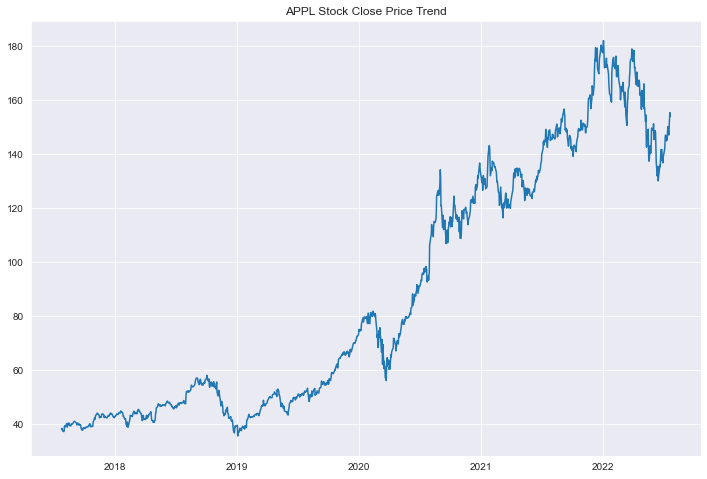

In [6]:
# Visualize the trend of Apple Stock
plt.figure(figsize=(12, 8))
plt.plot("Close", data=stock_data)
plt.title("APPL Stock Close Price Trend")

In [7]:
# Now we will have our dataset loader function

def dataset_loader(stock_name):
    dataset = data_reader.DataReader(stock_name, data_source="yahoo")

    start_date = str(dataset.index[0]).split()[0]
    end_date = str(dataset.index[-1]).split()[0]

    return dataset['Close']

In [8]:
stock_name = "AAPL"
data = dataset_loader(stock_name)
data.head()

Date
2017-07-24    38.022499
2017-07-25    38.185001
2017-07-26    38.365002
2017-07-27    37.639999
2017-07-28    37.375000
Name: Close, dtype: float64

## State Creator

In [9]:
# We have created the dataset from datareader - which looks up a finance data and brings back information on a particular stock
# Now we will create a state from it
'''
window_size - how many previous day we consider before we predict the current one
data - stock market data downloaded with the dataset loader function
timestep - day in the dataset in which we want to predict for
'''
def state_creator(data, timestep, window_size):
    starting_id = timestep-window_size + 1

    if starting_id >= 0:
        windowed_data = data[starting_id:timestep + 1]
    else:
        windowed_data = - starting_id * [data[0]] + list(data[0:timestep+1])

    state = []
    # iterating through the whole window of data
    for index in range(window_size - 1):
        # Normalize the difference between the next day and current day and considering only the difference of value of stocks
        state.append(sigmoid(windowed_data[index + 1] - windowed_data[index]))

    return np.array([state])

## Define the Trader Model and Setting the Hyper Parameter

In [10]:
# Hyperparameters
window_size = 10 # we will use 10 previous days to predict the correct one
episodes = 1000

batch_size = 32
data_samples = len(data) - 1

In [11]:
# Define the model
trader = AI_Trader(state_size=window_size)
trader.model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                352       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 387       
Total params: 11,171
Trainable params: 11,171
Non-trainable params: 0
_________________________________________________________________


2022-07-23 21:13:37.720391: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Training Loop

In [12]:
for episode in range(1, episodes + 1):
    print(f"Episodes - {episode} of {episodes}")

    state = state_creator(data, 0, window_size + 1)

    total_profit = 0
    trader.inventory = []

    for t in tqdm(range(data_samples)):
        action = trader.trade(state)

        next_state = state_creator(data, t+1, window_size + 1)
        reward = 0

        if action == 1: # Buying
            trader.inventory.append(data[t])
            print(f"AI Trader Bought - {stocks_price_format(data[t])}")

        elif action == 2 and len(trader.inventory) > 0: # Selling
            buy_price = trader.inventory.pop(0)

            reward = max(data[t] - buy_price, 0)
            total_profit += data[t] - buy_price
            print(f"AI Trader Sold - {stocks_price_format(data[t])}, Profit - {stocks_price_format(data[t] - buy_price)}")

        if t == data_samples - 1:
            done = True
        else:
            done = False

        trader.memory.append((state, action, reward, next_state, done))

        state = next_state

        if done:
            print("###############################################")
            print(f"Total Profit - {total_profit}")
            print("###############################################")

        if len(trader.memory) > batch_size:
            trader.batch_train(batch_size)

    if episode % 10 == 0:
        trader.model.save("ai_trader_{}.h5".format(episode))

Episodes - 1 of 1000


  0%|          | 0/1258 [00:00<?, ?it/s]2022-07-23 21:13:37.842873: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


AI Trader Bought - $ 39.285000
AI Trader Bought - $ 38.892502
AI Trader Bought - $ 39.097500
AI Trader Bought - $ 39.702499
AI Trader Sold - $ 40.020000, Profit - $ 0.735001
AI Trader Bought - $ 40.264999
AI Trader Sold - $ 38.830002, Profit - - $ 0.062500
AI Trader Bought - $ 39.369999
AI Trader Bought - $ 39.962502
AI Trader Sold - $ 40.400002, Profit - $ 1.302502
AI Trader Sold - $ 39.465000, Profit - - $ 0.237499
AI Trader Bought - $ 39.375000
AI Trader Sold - $ 39.302502, Profit - - $ 0.962498
AI Trader Sold - $ 39.945000, Profit - $ 0.575001
AI Trader Bought - $ 39.994999
AI Trader Bought - $ 40.367500
AI Trader Sold - $ 40.727501, Profit - $ 0.764999
AI Trader Sold - $ 40.837502, Profit - $ 1.462502
AI Trader Bought - $ 40.520000
AI Trader Bought - $ 40.477501


  3%|▎         | 33/1258 [00:02<01:39, 12.36it/s]

AI Trader Bought - $ 39.657501
AI Trader Sold - $ 40.375000, Profit - $ 0.380001


  3%|▎         | 35/1258 [00:07<05:11,  3.93it/s]

AI Trader Sold - $ 40.215000, Profit - - $ 0.152500


  3%|▎         | 36/1258 [00:09<07:11,  2.83it/s]

AI Trader Bought - $ 39.912498


  3%|▎         | 37/1258 [00:11<10:06,  2.01it/s]

AI Trader Sold - $ 39.570000, Profit - - $ 0.950001


  3%|▎         | 38/1258 [00:13<13:18,  1.53it/s]

AI Trader Bought - $ 39.970001


  3%|▎         | 39/1258 [00:16<17:12,  1.18it/s]

AI Trader Bought - $ 39.667500


  3%|▎         | 41/1258 [00:20<25:42,  1.27s/it]

AI Trader Sold - $ 39.017502, Profit - - $ 1.459999


  3%|▎         | 42/1258 [00:22<29:02,  1.43s/it]

AI Trader Bought - $ 38.347500


  3%|▎         | 43/1258 [00:25<32:13,  1.59s/it]

AI Trader Bought - $ 37.972500


  4%|▎         | 46/1258 [00:31<38:39,  1.91s/it]

AI Trader Sold - $ 38.557499, Profit - - $ 1.100002


  4%|▎         | 47/1258 [00:33<40:53,  2.03s/it]

AI Trader Bought - $ 38.320000


  4%|▍         | 48/1258 [00:36<42:10,  2.09s/it]

AI Trader Bought - $ 38.529999


Exception ignored in: <function ScopedTFGraph.__del__ at 0x7fefd5518af0>
Traceback (most recent call last):
  File "/Users/suvosmac/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/framework/c_api_util.py", line 58, in __del__
    self.deleter(self.graph)
KeyboardInterrupt: 
  4%|▍         | 49/1258 [00:38<43:00,  2.13s/it]

AI Trader Sold - $ 38.452499, Profit - - $ 1.459999


  4%|▍         | 50/1258 [00:40<42:40,  2.12s/it]

AI Trader Sold - $ 38.619999, Profit - - $ 1.350002


  4%|▍         | 51/1258 [00:42<44:23,  2.21s/it]

AI Trader Bought - $ 38.369999


  4%|▍         | 52/1258 [00:45<44:36,  2.22s/it]

AI Trader Sold - $ 38.847500, Profit - - $ 0.820000


  4%|▍         | 52/1258 [00:45<17:34,  1.14it/s]

KeyboardInterrupt

